In [2]:
from pyspark.sql import SparkSession, Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.pandas as ps

try:
    # Tworzenie sesji Spark
    spark = SparkSession.builder \
        .appName("PySpark SQL Server Connection") \
        .config("spark.jars", "mssql-jdbc-12.6.1.jre8.jar") \
        .getOrCreate()

    # Parametry połączenia z bazą danych MSSQL
    server_name = "mssql-server"
    port = "1433"
    database_name = "ETLKI"
    url = f"jdbc:sqlserver://{server_name}:{port};databaseName={database_name}"

    table_name = "ETLKI"
    username = "sa"
    password = "YourStrongPassword123"

    # Wczytanie danych z bazy danych MSSQL
    df = spark.read \
        .format("jdbc") \
        .option("url", url) \
        .option("dbtable", table_name) \
        .option("user", username) \
        .option("password", password) \
        .option("encrypt", "false") \
        .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
        .load()

    print("Dane zostały pomyślnie wczytane z MSSQL.")
    # Wyświetlenie pierwszych kilku wierszy DataFrame
    df.show(5)

except Exception as e:
    print("Wystąpił błąd podczas łączenia z bazą danych:", str(e))



Dane zostały pomyślnie wczytane z MSSQL.
+----------+---------+----------+----------+--------+----+----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------------+---------+--------------------+--------------+--------------------+------+-----------+--------+--------+--------+--------+--------------------+------------+-------+---------+------------------+-------------------+----------+---------------------------+---------------+-------------------+----------------+--------------------+---------------+-------------+----+-----------+---------------+
|Unnamed: 0|    DR_NO| Date Rptd|  DATE OCC|TIME OCC|AREA| AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|      Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status|Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|Cross Street|    LAT|      LON|gender of criminal|country of criminal|kill

### przewidywania na szeregach czasowych

In [3]:
df.columns

['Unnamed: 0',
 'DR_NO',
 'Date Rptd',
 'DATE OCC',
 'TIME OCC',
 'AREA',
 'AREA NAME',
 'Rpt Dist No',
 'Part 1-2',
 'Crm Cd',
 'Crm Cd Desc',
 'Mocodes',
 'Vict Age',
 'Vict Sex',
 'Vict Descent',
 'Premis Cd',
 'Premis Desc',
 'Weapon Used Cd',
 'Weapon Desc',
 'Status',
 'Status Desc',
 'Crm Cd 1',
 'Crm Cd 2',
 'Crm Cd 3',
 'Crm Cd 4',
 'LOCATION',
 'Cross Street',
 'LAT',
 'LON',
 'gender of criminal',
 'country of criminal',
 'kill count',
 'marital status of criminal ',
 'age of criminal',
 'previously punished',
 'education levels',
 'drug substances',
 'annual earnings',
 'value_divided',
 'Time',
 'Day of Week',
 'Vict Age bucket']

In [4]:
# zliczanie ilości zabitych w danym dniu

In [5]:
from pyspark.sql.functions import sum

# Grupowanie danych i zliczanie kill count w danej dacie
kill_count_by_date = df.groupBy("Date Rptd").agg(sum("kill count").alias("Total Kill Count"))

# Wyświetlenie wyników
kill_count_by_date.show()

# Połączenie wyników z oryginalną ramką danych
df_with_kill_count = df.join(kill_count_by_date, "Date Rptd", "left")


+----------+----------------+
| Date Rptd|Total Kill Count|
+----------+----------------+
|2021-12-18|               5|
|2022-08-02|               5|
|2022-12-25|               6|
|2022-07-27|               0|
|2022-11-29|               8|
|2020-08-29|               7|
|2023-06-18|               2|
|2021-04-29|               0|
|2022-01-29|               1|
|2022-05-26|               0|
|2020-03-07|               0|
|2021-07-17|               0|
|2023-06-23|               0|
|2020-02-15|               0|
|2021-09-11|               0|
|2022-07-07|               0|
|2021-02-15|               0|
|2022-12-09|               3|
|2022-04-02|               1|
|2022-03-12|               2|
+----------+----------------+
only showing top 20 rows



# *Tworzenie przewidywań na szeregach czasowych* na danyh dotyczących ilości zabitych  w danym dniu
* *ARIMA*
* *XGBOOST*
*  *Regresja liniowa*
*  *Random forrest regression*

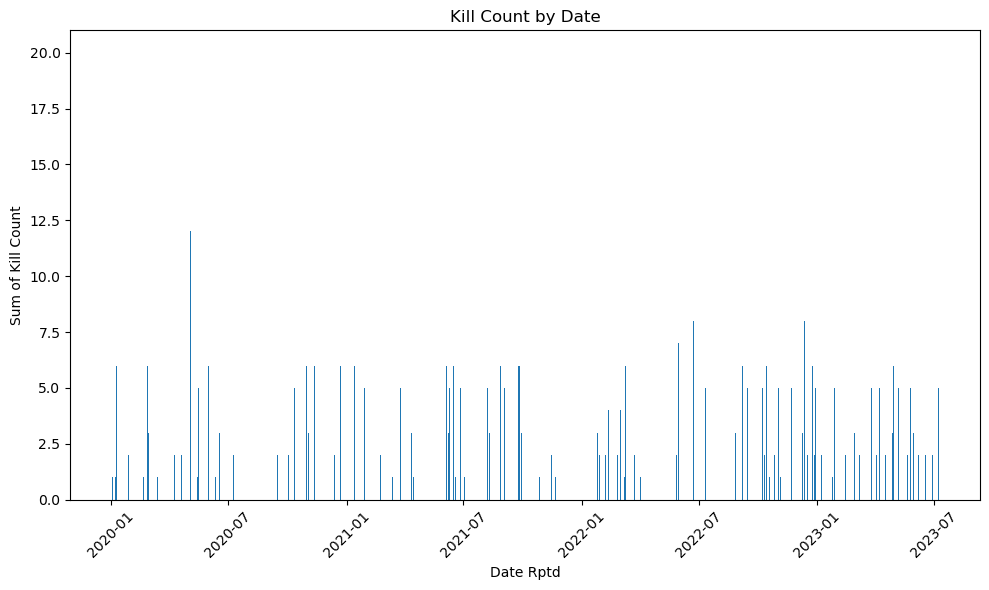

In [7]:
import matplotlib.pyplot as plt

# Konwersja danych do list Pythona
date_rptd = kill_count_by_date.select("Date Rptd").rdd.flatMap(lambda x: x).collect()
kill_count = kill_count_by_date.select("Total Kill Count").rdd.flatMap(lambda x: x).collect()

# Wykres słupkowy
plt.figure(figsize=(10, 6))
plt.bar(date_rptd, kill_count)
plt.xlabel('Date Rptd')
plt.ylabel('Sum of Kill Count')
plt.title('Kill Count by Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


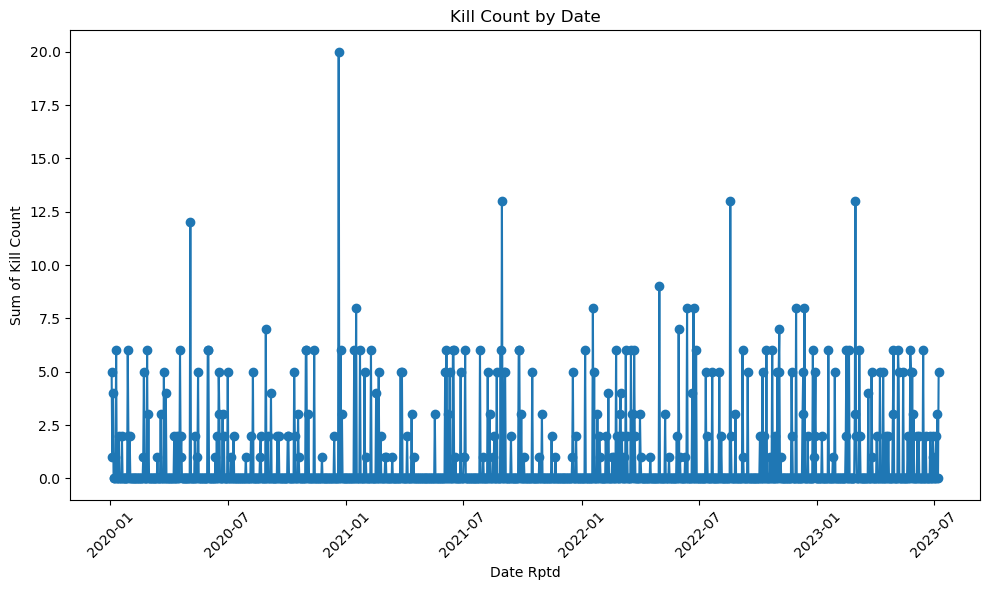

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Konwersja danych do list Pythona
date_rptd = kill_count_by_date.select("Date Rptd").rdd.flatMap(lambda x: x).collect()
kill_count = kill_count_by_date.select("Total Kill Count").rdd.flatMap(lambda x: x).collect()

# Utworzenie ramki danych pandas
df = pd.DataFrame({'Date Rptd': date_rptd, 'Sum of Kill Count': kill_count})
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])  # Konwersja do typu daty

# Uzupełnienie brakujących dat
all_dates = pd.date_range(start=df['Date Rptd'].min(), end=df['Date Rptd'].max())
existing_dates = pd.to_datetime(df['Date Rptd']).tolist()
missing_dates = [date for date in all_dates if date not in existing_dates]
missing_data = pd.DataFrame({'Date Rptd': missing_dates, 'Sum of Kill Count': 0})
df = pd.concat([df, missing_data]).sort_values('Date Rptd').reset_index(drop=True)

# Wykres szeregu czasowego
plt.figure(figsize=(10, 6))
plt.plot(df['Date Rptd'], df['Sum of Kill Count'], marker='o', linestyle='-')
plt.xlabel('Date Rptd')
plt.ylabel('Sum of Kill Count')
plt.title('Kill Count by Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# ARIMA 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd

# Konwersja danych do list Pythona
date_rptd = kill_count_by_date.select("Date Rptd").rdd.flatMap(lambda x: x).collect()
kill_count = kill_count_by_date.select("Total Kill Count").rdd.flatMap(lambda x: x).collect()

# Utworzenie ramki danych pandas
df = pd.DataFrame({'Date Rptd': date_rptd, 'Sum of Kill Count': kill_count})
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])  # Konwersja do typu daty

# Uzupełnienie brakujących dat
all_dates = pd.date_range(start=df['Date Rptd'].min(), end=df['Date Rptd'].max())
existing_dates = pd.to_datetime(df['Date Rptd']).tolist()
missing_dates = [date for date in all_dates if date not in existing_dates]
missing_data = pd.DataFrame({'Date Rptd': missing_dates, 'Sum of Kill Count': 0})
df = pd.concat([df, missing_data]).sort_values('Date Rptd').reset_index(drop=True)

# Dopasowanie modelu ARIMA
model = ARIMA(df['Sum of Kill Count'], order=(5,1,0))
model_fit = model.fit()

# Prognoza na kolejny rok
forecast = model_fit.forecast(steps=12)

# Wykres szeregu czasowego z prognozą
plt.figure(figsize=(10, 6))
plt.plot(df['Date Rptd'], df['Sum of Kill Count'], marker='o', linestyle='-', label='Actual')
plt.plot(pd.date_range(start=df['Date Rptd'].max(), periods=12, freq='M'), forecast, marker='o', linestyle='--', color='red', label='Forecast')
plt.xlabel('Date Rptd')
plt.ylabel('Sum of Kill Count')
plt.title('Kill Count by Date with Forecast')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
## Regesja liniowa

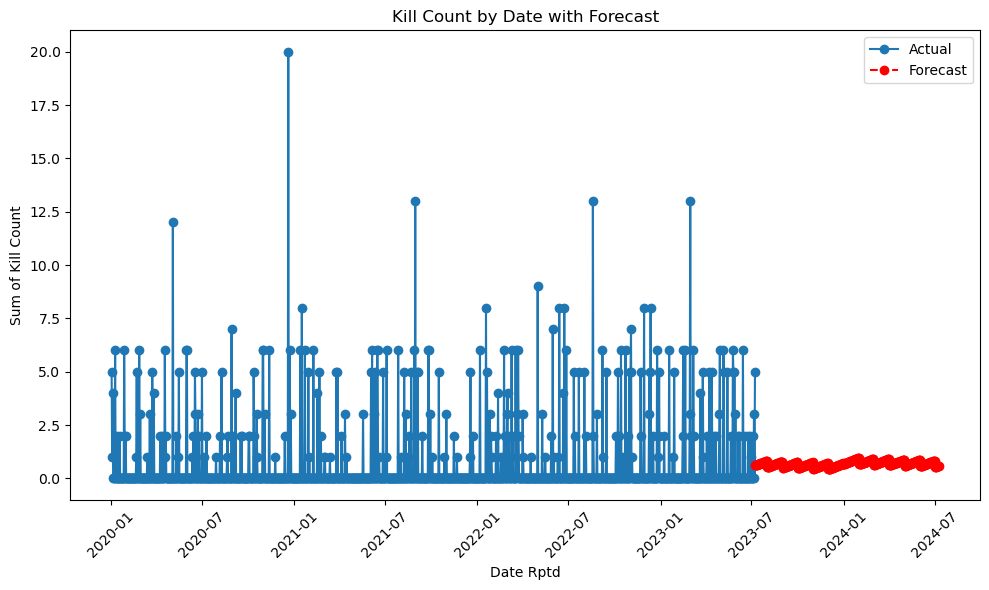

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd

# Konwersja danych do list Pythona
date_rptd = kill_count_by_date.select("Date Rptd").rdd.flatMap(lambda x: x).collect()
kill_count = kill_count_by_date.select("Total Kill Count").rdd.flatMap(lambda x: x).collect()

# Utworzenie ramki danych pandas
df = pd.DataFrame({'Date Rptd': date_rptd, 'Sum of Kill Count': kill_count})
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])  # Konwersja do typu daty

# Uzupełnienie brakujących dat
all_dates = pd.date_range(start=df['Date Rptd'].min(), end=df['Date Rptd'].max())
existing_dates = pd.to_datetime(df['Date Rptd']).tolist()
missing_dates = [date for date in all_dates if date not in existing_dates]
missing_data = pd.DataFrame({'Date Rptd': missing_dates, 'Sum of Kill Count': 0})
df = pd.concat([df, missing_data]).sort_values('Date Rptd').reset_index(drop=True)

# Przygotowanie danych do modelu regresji
df['Month'] = df['Date Rptd'].dt.month
df['Day'] = df['Date Rptd'].dt.day
X = df[['Month', 'Day']]
y = df['Sum of Kill Count']

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dopasowanie modelu regresji liniowej
model = LinearRegression()
model.fit(X_train, y_train)

# Prognoza na kolejny rok
next_year_dates = pd.date_range(start=df['Date Rptd'].max() + pd.DateOffset(days=1), end=df['Date Rptd'].max() + pd.DateOffset(years=1), freq='D')
next_year_X = pd.DataFrame({'Month': next_year_dates.month, 'Day': next_year_dates.day})
forecast = model.predict(next_year_X)

# Wykres szeregu czasowego z prognozą
plt.figure(figsize=(10, 6))
plt.plot(df['Date Rptd'], df['Sum of Kill Count'], marker='o', linestyle='-', label='Actual')
plt.plot(next_year_dates, forecast, marker='o', linestyle='--', color='red', label='Forecast')
plt.xlabel('Date Rptd')
plt.ylabel('Sum of Kill Count')
plt.title('Kill Count by Date with Forecast')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# XGBOOST

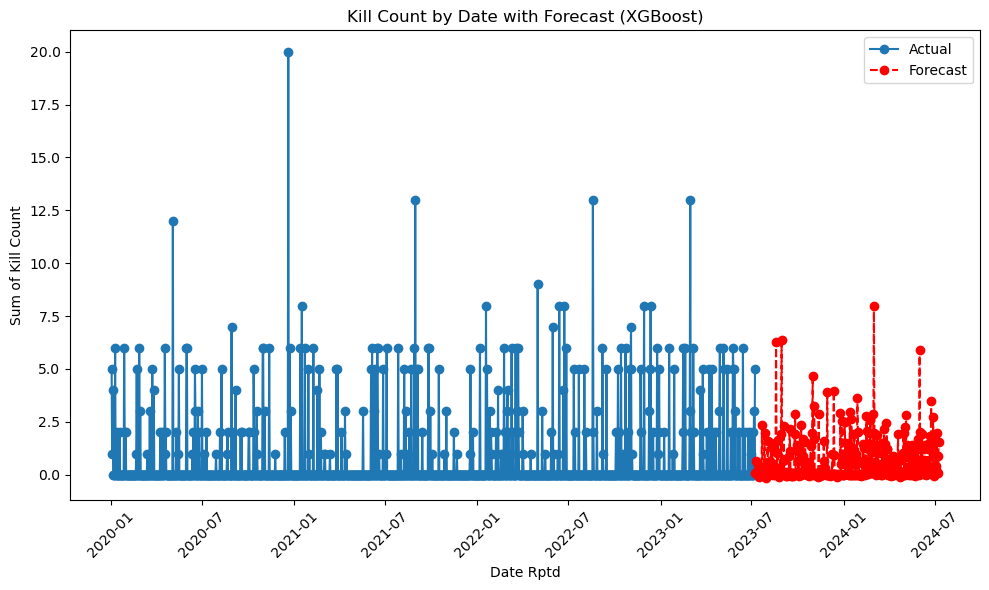

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Konwersja danych do list Pythona
date_rptd = kill_count_by_date.select("Date Rptd").rdd.flatMap(lambda x: x).collect()
kill_count = kill_count_by_date.select("Total Kill Count").rdd.flatMap(lambda x: x).collect()

# Utworzenie ramki danych pandas
df = pd.DataFrame({'Date Rptd': date_rptd, 'Sum of Kill Count': kill_count})
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])  # Konwersja do typu daty

# Uzupełnienie brakujących dat
all_dates = pd.date_range(start=df['Date Rptd'].min(), end=df['Date Rptd'].max())
existing_dates = pd.to_datetime(df['Date Rptd']).tolist()
missing_dates = [date for date in all_dates if date not in existing_dates]
missing_data = pd.DataFrame({'Date Rptd': missing_dates, 'Sum of Kill Count': 0})
df = pd.concat([df, missing_data]).sort_values('Date Rptd').reset_index(drop=True)

# Przygotowanie danych do modelu XGBoost
df['Month'] = df['Date Rptd'].dt.month
df['Day'] = df['Date Rptd'].dt.day
X = df[['Month', 'Day']]
y = df['Sum of Kill Count']

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dopasowanie modelu XGBoost
model = xgb.XGBRegressor(objective ='reg:squarederror', seed=42)
model.fit(X_train, y_train)

# Prognoza na kolejny rok
next_year_dates = pd.date_range(start=df['Date Rptd'].max() + pd.DateOffset(days=1), end=df['Date Rptd'].max() + pd.DateOffset(years=1), freq='D')
next_year_X = pd.DataFrame({'Month': next_year_dates.month, 'Day': next_year_dates.day})
forecast = model.predict(next_year_X)

# Wykres szeregu czasowego z prognozą
plt.figure(figsize=(10, 6))
plt.plot(df['Date Rptd'], df['Sum of Kill Count'], marker='o', linestyle='-', label='Actual')
plt.plot(next_year_dates, forecast, marker='o', linestyle='--', color='red', label='Forecast')
plt.xlabel('Date Rptd')
plt.ylabel('Sum of Kill Count')
plt.title('Kill Count by Date with Forecast (XGBoost)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
## Random Forest Regressor

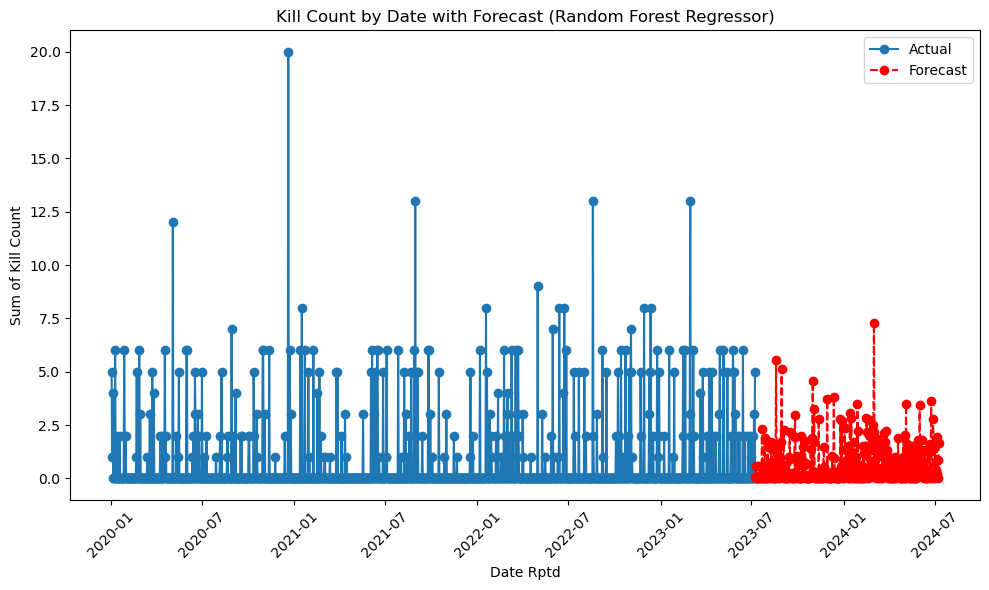

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Konwersja danych do list Pythona
date_rptd = kill_count_by_date.select("Date Rptd").rdd.flatMap(lambda x: x).collect()
kill_count = kill_count_by_date.select("Total Kill Count").rdd.flatMap(lambda x: x).collect()

# Utworzenie ramki danych pandas
df = pd.DataFrame({'Date Rptd': date_rptd, 'Sum of Kill Count': kill_count})
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])  # Konwersja do typu daty

# Uzupełnienie brakujących dat
all_dates = pd.date_range(start=df['Date Rptd'].min(), end=df['Date Rptd'].max())
existing_dates = pd.to_datetime(df['Date Rptd']).tolist()
missing_dates = [date for date in all_dates if date not in existing_dates]
missing_data = pd.DataFrame({'Date Rptd': missing_dates, 'Sum of Kill Count': 0})
df = pd.concat([df, missing_data]).sort_values('Date Rptd').reset_index(drop=True)

# Przygotowanie danych do modelu Random Forest Regressor
df['Month'] = df['Date Rptd'].dt.month
df['Day'] = df['Date Rptd'].dt.day
X = df[['Month', 'Day']]
y = df['Sum of Kill Count']

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dopasowanie modelu Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Prognoza na kolejny rok
next_year_dates = pd.date_range(start=df['Date Rptd'].max() + pd.DateOffset(days=1), end=df['Date Rptd'].max() + pd.DateOffset(years=1), freq='D')
next_year_X = pd.DataFrame({'Month': next_year_dates.month, 'Day': next_year_dates.day})
forecast = model.predict(next_year_X)

# Wykres szeregu czasowego z prognozą
plt.figure(figsize=(10, 6))
plt.plot(df['Date Rptd'], df['Sum of Kill Count'], marker='o', linestyle='-', label='Actual')
plt.plot(next_year_dates, forecast, marker='o', linestyle='--', color='red', label='Forecast')
plt.xlabel('Date Rptd')
plt.ylabel('Sum of Kill Count')
plt.title('Kill Count by Date with Forecast (Random Forest Regressor)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
from pyspark.sql import SparkSession, Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.pandas as ps

try:
    # Tworzenie sesji Spark
    spark = SparkSession.builder \
        .appName("PySpark SQL Server Connection") \
        .config("spark.jars", "mssql-jdbc-12.6.1.jre8.jar") \
        .getOrCreate()

    # Parametry połączenia z bazą danych MSSQL
    server_name = "mssql-server"
    port = "1433"
    database_name = "ETLKI"
    url = f"jdbc:sqlserver://{server_name}:{port};databaseName={database_name}"

    table_name = "ETLKI"
    username = "sa"
    password = "YourStrongPassword123"

    # Wczytanie danych z bazy danych MSSQL
    df = spark.read \
        .format("jdbc") \
        .option("url", url) \
        .option("dbtable", table_name) \
        .option("user", username) \
        .option("password", password) \
        .option("encrypt", "false") \
        .option("driver", "com.microsoft.sqlserver.jdbc.SQLServerDriver") \
        .load()

    print("Dane zostały pomyślnie wczytane z MSSQL.")
    # Wyświetlenie pierwszych kilku wierszy DataFrame
    df.show(5)

except Exception as e:
    print("Wystąpił błąd podczas łączenia z bazą danych:", str(e))



Dane zostały pomyślnie wczytane z MSSQL.
+----------+---------+----------+----------+--------+----+----------+-----------+--------+------+--------------------+--------------------+--------+--------+------------------+---------+--------------------+--------------+--------------------+------+-----------+--------+--------+--------+--------+--------------------+------------+-------+---------+------------------+-------------------+----------+---------------------------+---------------+-------------------+----------------+--------------------+---------------+-------------+----+-----------+---------------+
|Unnamed: 0|    DR_NO| Date Rptd|  DATE OCC|TIME OCC|AREA| AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|      Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status|Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|Cross Street|    LAT|      LON|gender of criminal|country of criminal|kill

In [ ]:
# zliczanie ilości przestepstw

In [21]:
count_by_date = df.groupBy("Date Rptd").count()

# Wyświetlenie wyników
count_by_date.show()

+----------+-----+
| Date Rptd|count|
+----------+-----+
|2021-12-18|    1|
|2022-08-02|    1|
|2022-12-25|    1|
|2022-07-27|    1|
|2022-11-29|    2|
|2020-08-29|    1|
|2023-06-18|    1|
|2021-04-29|    1|
|2022-01-29|    1|
|2022-05-26|    1|
|2020-03-07|    1|
|2021-07-17|    1|
|2023-06-23|    1|
|2020-02-15|    1|
|2021-09-11|    1|
|2022-07-07|    1|
|2021-02-15|    1|
|2022-12-09|    1|
|2022-04-02|    3|
|2022-03-12|    1|
+----------+-----+
only showing top 20 rows



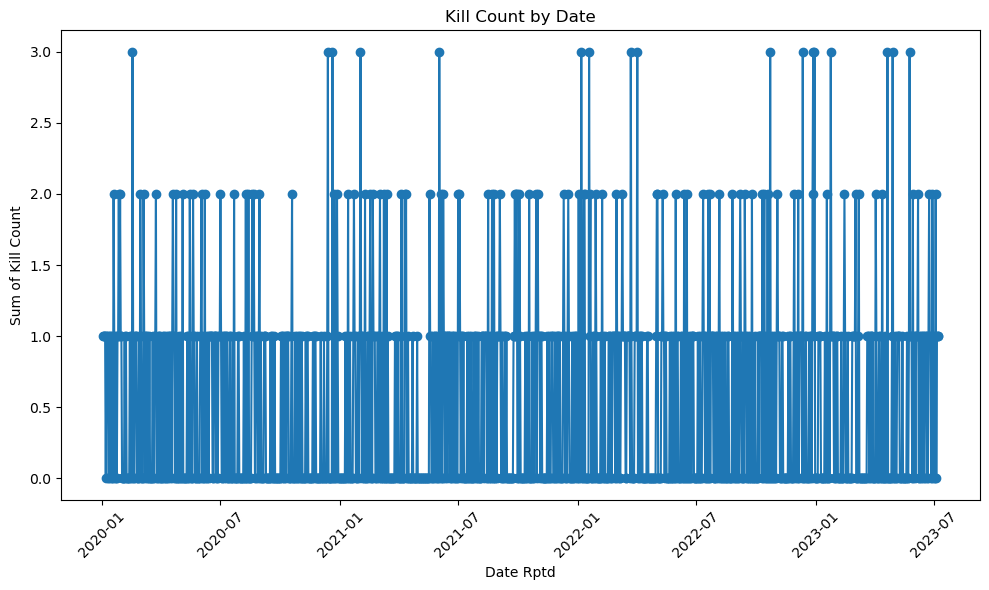

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Konwersja danych do list Pythona
date_rptd = count_by_date.select("Date Rptd").rdd.flatMap(lambda x: x).collect()
kill_count = count_by_date.select("count").rdd.flatMap(lambda x: x).collect()

# Utworzenie ramki danych pandas
df = pd.DataFrame({'Date Rptd': date_rptd, 'Sum of Kill Count': kill_count})
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])  # Konwersja do typu daty

# Uzupełnienie brakujących dat
all_dates = pd.date_range(start=df['Date Rptd'].min(), end=df['Date Rptd'].max())
existing_dates = pd.to_datetime(df['Date Rptd']).tolist()
missing_dates = [date for date in all_dates if date not in existing_dates]
missing_data = pd.DataFrame({'Date Rptd': missing_dates, 'Sum of Kill Count': 0})
df = pd.concat([df, missing_data]).sort_values('Date Rptd').reset_index(drop=True)

# Wykres szeregu czasowego
plt.figure(figsize=(10, 6))
plt.plot(df['Date Rptd'], df['Sum of Kill Count'], marker='o', linestyle='-')
plt.xlabel('Date Rptd')
plt.ylabel('Sum of Kill Count')
plt.title('Kill Count by Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


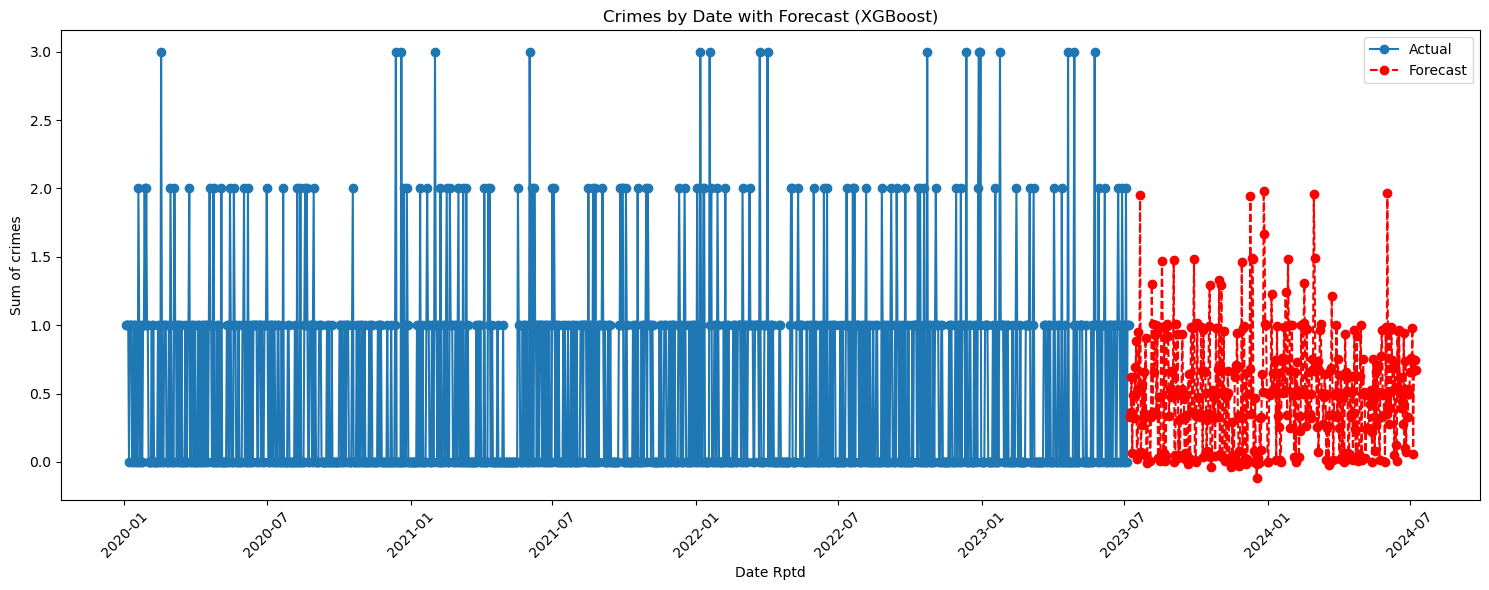

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Konwersja danych do list Pythona
date_rptd = count_by_date.select("Date Rptd").rdd.flatMap(lambda x: x).collect()
kill_count = count_by_date.select("count").rdd.flatMap(lambda x: x).collect()

# Utworzenie ramki danych pandas
df = pd.DataFrame({'Date Rptd': date_rptd, 'Sum of Kill Count': kill_count})
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])  # Konwersja do typu daty

# Uzupełnienie brakujących dat
all_dates = pd.date_range(start=df['Date Rptd'].min(), end=df['Date Rptd'].max())
existing_dates = pd.to_datetime(df['Date Rptd']).tolist()
missing_dates = [date for date in all_dates if date not in existing_dates]
missing_data = pd.DataFrame({'Date Rptd': missing_dates, 'Sum of Kill Count': 0})
df = pd.concat([df, missing_data]).sort_values('Date Rptd').reset_index(drop=True)

# Przygotowanie danych do modelu XGBoost
df['Month'] = df['Date Rptd'].dt.month
df['Day'] = df['Date Rptd'].dt.day
X = df[['Month', 'Day']]
y = df['Sum of Kill Count']

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dopasowanie modelu XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)
model.fit(X_train, y_train)

# Prognoza na kolejny rok
next_year_dates = pd.date_range(start=df['Date Rptd'].max() + pd.DateOffset(days=1), end=df['Date Rptd'].max() + pd.DateOffset(years=1), freq='D')
next_year_X = pd.DataFrame({'Month': next_year_dates.month, 'Day': next_year_dates.day})
forecast = model.predict(next_year_X)

# Wykres szeregu czasowego z prognozą (szerszy)
plt.figure(figsize=(15, 6))  # Zmiana szerokości na 15 cali
plt.plot(df['Date Rptd'], df['Sum of Kill Count'], marker='o', linestyle='-', label='Actual')
plt.plot(next_year_dates, forecast, marker='o', linestyle='--', color='red', label='Forecast')
plt.xlabel('Date Rptd')
plt.ylabel('Sum of crimes')
plt.title('Crimes by Date with Forecast (XGBoost)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


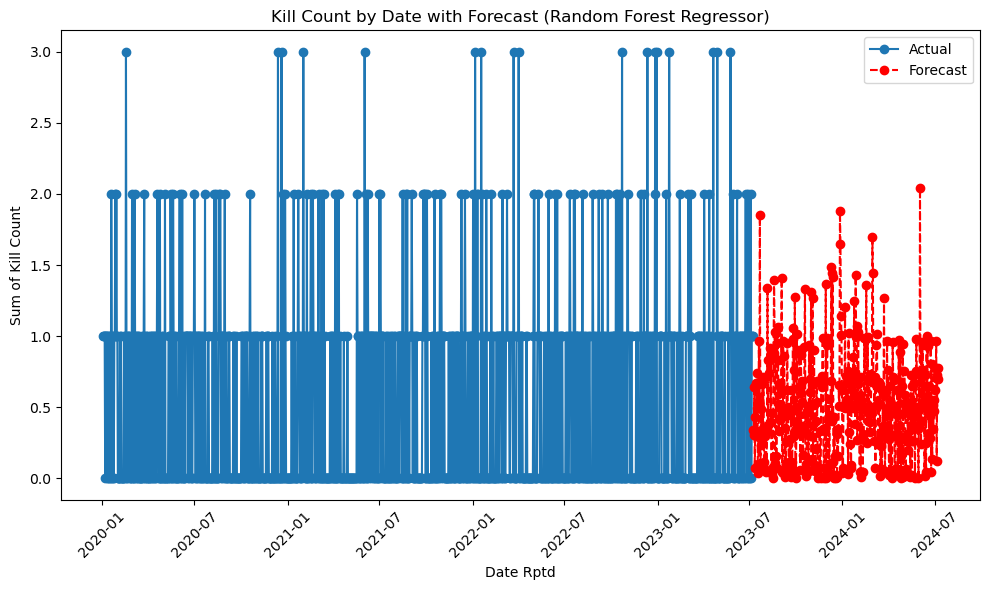

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Konwersja danych do list Pythona
date_rptd = count_by_date.select("Date Rptd").rdd.flatMap(lambda x: x).collect()
kill_count = count_by_date.select("count").rdd.flatMap(lambda x: x).collect()

# Utworzenie ramki danych pandas
df = pd.DataFrame({'Date Rptd': date_rptd, 'Sum of Kill Count': kill_count})
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])  # Konwersja do typu daty

# Uzupełnienie brakujących dat
all_dates = pd.date_range(start=df['Date Rptd'].min(), end=df['Date Rptd'].max())
existing_dates = pd.to_datetime(df['Date Rptd']).tolist()
missing_dates = [date for date in all_dates if date not in existing_dates]
missing_data = pd.DataFrame({'Date Rptd': missing_dates, 'Sum of Kill Count': 0})
df = pd.concat([df, missing_data]).sort_values('Date Rptd').reset_index(drop=True)

# Przygotowanie danych do modelu Random Forest Regressor
df['Month'] = df['Date Rptd'].dt.month
df['Day'] = df['Date Rptd'].dt.day
X = df[['Month', 'Day']]
y = df['Sum of Kill Count']

# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dopasowanie modelu Random Forest Regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Prognoza na kolejny rok
next_year_dates = pd.date_range(start=df['Date Rptd'].max() + pd.DateOffset(days=1), end=df['Date Rptd'].max() + pd.DateOffset(years=1), freq='D')
next_year_X = pd.DataFrame({'Month': next_year_dates.month, 'Day': next_year_dates.day})
forecast = model.predict(next_year_X)

# Wykres szeregu czasowego z prognozą
plt.figure(figsize=(10, 6))
plt.plot(df['Date Rptd'], df['Sum of Kill Count'], marker='o', linestyle='-', label='Actual')
plt.plot(next_year_dates, forecast, marker='o', linestyle='--', color='red', label='Forecast')
plt.xlabel('Date Rptd')
plt.ylabel('Sum of Kill Count')
plt.title('Kill Count by Date with Forecast (Random Forest Regressor)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
